# minLSTM and minGRU implementation (classification task)

paper: [Were RNNs All We Needed?](https://arxiv.org/pdf/2410.01201)

разбор: [мой разбор этой статьи](https://share.note.sx/etmja30i#PTNWripUEx5ttV709qDAPBZtqO76h/cJZkEWLhMKdoA)

In [ ]:
!pip install datasets -qq

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

## Text preprocessing

In [4]:
dataset = load_dataset('ai-forever/kinopoisk-sentiment-classification')
train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['validation']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/104 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/37.1M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/5.39M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/5.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [5]:
train_dataset, test_dataset, val_dataset

(Dataset({
     features: ['id', 'text', 'label', 'label_text'],
     num_rows: 10500
 }),
 Dataset({
     features: ['id', 'text', 'label', 'label_text'],
     num_rows: 1500
 }),
 Dataset({
     features: ['id', 'text', 'label', 'label_text'],
     num_rows: 1500
 }))

In [6]:
# WordPiece tokenizer (it was used in BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
lengths = []
for text in train_dataset['text']:
  lengths.append(len(tokenizer(text)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (1860 > 512). Running this sequence through the model will result in indexing errors


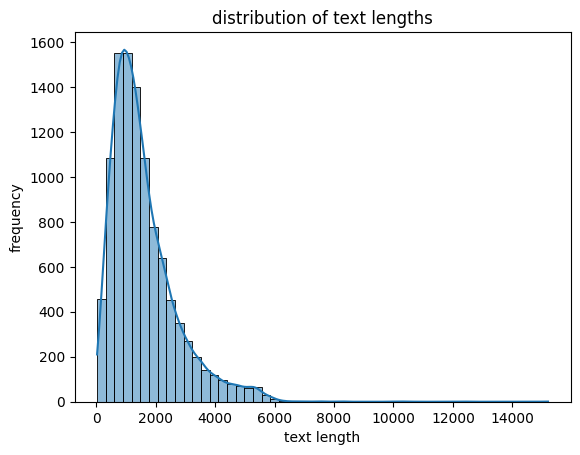

In [8]:
lengths_df = pd.Series(lengths)
sns.histplot(data=lengths_df, kde=True, bins=52)

plt.title('distribution of text lengths')
plt.xlabel('text length')
plt.ylabel('frequency')

plt.show()

In [9]:
lengths_df.describe()

,0
count,10500.000000
mean,1592.728000
std,1110.425223
min,31.000000
25%,825.000000
50%,1312.500000
75%,2064.000000
max,15196.000000


In [10]:
# max_length=2064 -> 75% percentile maybe more reasonable (or maybe not)
# I chose 512 just because this is a tutorial (i don't have enough time and compute)

def preprocess(example):
  inputs = tokenizer(example['text'], max_length=512,
                     padding='max_length', truncation=True)
  inputs['target'] = example['label']
  return inputs

In [11]:
tokenized_train_dataset = train_dataset.map(preprocess, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/10500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [12]:
tokenized_train_dataset = tokenized_train_dataset.select_columns(['input_ids', 'target', 'attention_mask'])
tokenized_test_dataset = tokenized_test_dataset.select_columns(['input_ids', 'target', 'attention_mask'])
tokenized_val_dataset = tokenized_val_dataset.select_columns(['input_ids', 'target', 'attention_mask'])

In [13]:
tokenized_train_dataset.set_format(type='torch')
tokenized_test_dataset.set_format(type='torch')
tokenized_val_dataset.set_format(type='torch')

In [14]:
batch_size = 64

train_loader = DataLoader(tokenized_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized_test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(tokenized_val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
for batch in train_loader:
    input_ids = batch['input_ids']
    target = batch['target']
    attn_mask = batch['attention_mask']
    print(input_ids.shape)
    print(target.shape)
    print(attn_mask.shape)
    break

torch.Size([64, 512])
torch.Size([64])
torch.Size([64, 512])


## Training and evaluating pipeline

In [16]:
vocab_size = tokenizer.vocab_size
vocab_size

28996

In [17]:
PAD = tokenizer.pad_token_id
PAD

0

In [18]:
def train_and_evaluate(model, train_dataloader, test_dataloader, val_dataloader,
                       loss_fn, optimizer, num_epochs=3):
  for epoch in range(num_epochs):
    training_loss = 0.0
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader)):
      input_ids = batch['input_ids'].to(device) # (batch_size, seq_len)
      target = batch['target'].to(device) # (batch_size)

      logits = model(input_ids) # (batch_size, num_classes)
      loss = loss_fn(logits, target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_loss += loss.item()

      if idx % 100 == 0:
        print(f'epoch: {epoch}, step: {idx}, train ce_loss: {training_loss/(idx+1)}')

    model.eval()
    test_loss = 0.0
    for idx, batch in enumerate(test_dataloader):
      input_ids = batch['input_ids'].to(device)
      target = batch['target'].to(device)

      with torch.no_grad():
        logits = model(input_ids)
        loss = loss_fn(logits, target)
        test_loss += loss.item()

    print(f'epoch: {epoch}, \
            train ce_loss: {training_loss/len(train_dataloader)}, \
            test ce_loss: {test_loss/len(test_dataloader)}')

  model.eval()
  with torch.no_grad():
    y_preds = []
    y_reals = []
    for idx, batch in enumerate(val_dataloader):
      input_ids = batch['input_ids'].to(device)
      target = batch['target'].to(device)

      logits = model(input_ids) # (batch_size, num_classes)
      preds = torch.argmax(logits, dim=-1).tolist() # (batch_size, 1).tolist() -> len = batch_size
      y_preds.extend(preds)
      y_reals.extend(target.tolist())

  print(classification_report(y_reals, y_preds, labels=[0, 1, 2]))

## LSTM

In [ ]:
class LSTM(nn.Module):
  def __init__(self, vocab_size, hidden_size=512, emb_size=512,
               num_classes=3, num_layers=1, device='cpu'):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.emb = nn.Embedding(vocab_size, emb_size)

    # emb_size+hidden_size -> concatenation(x_t, h_t_min1)
    self.linear_ft = nn.ModuleList([nn.Linear(emb_size+hidden_size, hidden_size) for layer in range(num_layers)])
    self.linear_it = nn.ModuleList([nn.Linear(emb_size+hidden_size, hidden_size) for layer in range(num_layers)])
    self.linear_c_wavy_t = nn.ModuleList([nn.Linear(emb_size+hidden_size, hidden_size) for layer in range(num_layers)])
    self.linear_ot = nn.ModuleList([nn.Linear(emb_size+hidden_size, hidden_size) for layer in range(num_layers)])

    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

    self.final_proj = nn.Linear(hidden_size, hidden_size)
    self.relu = nn.LeakyReLU(hidden_size)
    self.classification_head = nn.Linear(hidden_size, num_classes)

  def forward(self, inp_tokens):
    # inp_tokens.shape -> (batch_size, seq_len) # seq_len is a number of tokens in an input sequence
    batch_size, seq_len = inp_tokens.shape
    inp_embs = self.emb(inp_tokens) # inp_embs.shape -> (batch_size, seq_len, emb_size)

    cell_states = {layer: torch.zeros((batch_size, self.hidden_size), device=self.device, dtype=torch.float32, requires_grad=True) for layer in range(self.num_layers)}
    hidden_states = {layer: torch.zeros((batch_size, self.hidden_size), device=self.device, dtype=torch.float32, requires_grad=True) for layer in range(self.num_layers)}

    for i in range(seq_len):
        current_input = inp_embs[:, i, :].squeeze(1) # (batch_size, emb_size)

        for layer in range(self.num_layers):
            concat_input = torch.cat((hidden_states[layer], current_input), dim=-1)  # (batch_size, hidden_size+emb_size)

            forget_gate = self.sigmoid(self.linear_ft[layer](concat_input)) # (batch_size, hidden_size)
            input_gate = self.sigmoid(self.linear_it[layer](concat_input)) # (batch_size, hidden_size)
            candidate_wavy_gate = self.tanh(self.linear_c_wavy_t[layer](concat_input)) # (batch_size, hidden_size)
            output_gate = self.sigmoid(self.linear_ot[layer](concat_input)) # (batch_size, hidden_size)
            # element-wise multiplication ('*', because of the same shape):
            cell_states[layer] = forget_gate * cell_states[layer] + input_gate * candidate_wavy_gate # (batch_size, hidden_size)
            hidden_states[layer] = output_gate * self.tanh(cell_states[layer]) # (batch_size, hidden_size)

            current_input = hidden_states[layer] # (batch_size, hidden_size)

    out = self.relu(self.final_proj(hidden_states[self.num_layers - 1])) # (batch_size, hidden_size)
    return self.classification_head(out)  # (batch_size, num_classes)

In [ ]:
lstm = LSTM(vocab_size=vocab_size, num_classes=3,
            num_layers=2, device=device).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
opt = torch.optim.AdamW(lstm.parameters(), lr=3e-4)

In [ ]:
train_and_evaluate(model=lstm, train_dataloader=train_loader, test_dataloader=test_loader,
                   val_dataloader=val_loader, loss_fn=loss_fn, optimizer=opt, num_epochs=10)

0it [00:00, ?it/s]

epoch: 0, step: 0, train ce_loss: 4.885061740875244
epoch: 0, step: 100, train ce_loss: 1.495325737660474
epoch: 0,             train ce_loss: 1.2265336892821572,             test ce_loss: 0.8090464497605959


0it [00:00, ?it/s]

epoch: 1, step: 0, train ce_loss: 0.8092121481895447
epoch: 1, step: 100, train ce_loss: 0.744745113471947
epoch: 1,             train ce_loss: 0.7508474667867024,             test ce_loss: 0.7337784096598625


0it [00:00, ?it/s]

epoch: 2, step: 0, train ce_loss: 0.6424419283866882
epoch: 2, step: 100, train ce_loss: 0.740829333220378
epoch: 2,             train ce_loss: 0.7426416072881583,             test ce_loss: 0.7514549667636553


0it [00:00, ?it/s]

epoch: 3, step: 0, train ce_loss: 0.7954386472702026
epoch: 3, step: 100, train ce_loss: 0.7219778092780916
epoch: 3,             train ce_loss: 0.7270154042677446,             test ce_loss: 0.9212968597809473


0it [00:00, ?it/s]

epoch: 4, step: 0, train ce_loss: 0.9690412878990173
epoch: 4, step: 100, train ce_loss: 0.6967104183565273
epoch: 4,             train ce_loss: 0.7154523889223735,             test ce_loss: 0.7629255379239718


0it [00:00, ?it/s]

epoch: 5, step: 0, train ce_loss: 0.7237498760223389
epoch: 5, step: 100, train ce_loss: 0.7349476914594669
epoch: 5,             train ce_loss: 0.7488473614056905,             test ce_loss: 1.0800464004278183


0it [00:00, ?it/s]

epoch: 6, step: 0, train ce_loss: 1.0910688638687134
epoch: 6, step: 100, train ce_loss: 0.6981930036355953
epoch: 6,             train ce_loss: 0.6945189038912455,             test ce_loss: 0.8391186768809954


0it [00:00, ?it/s]

epoch: 7, step: 0, train ce_loss: 0.6239853501319885
epoch: 7, step: 100, train ce_loss: 0.6815224059737555
epoch: 7,             train ce_loss: 0.6781420420516621,             test ce_loss: 1.075239102045695


0it [00:00, ?it/s]

epoch: 8, step: 0, train ce_loss: 1.0046331882476807
epoch: 8, step: 100, train ce_loss: 0.6972728238837553
epoch: 8,             train ce_loss: 0.697508325179418,             test ce_loss: 0.8151763727267584


0it [00:00, ?it/s]

epoch: 9, step: 0, train ce_loss: 0.6490188837051392
epoch: 9, step: 100, train ce_loss: 0.6552036935740179
epoch: 9,             train ce_loss: 0.6528387535702098,             test ce_loss: 0.8887561311324438
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.36      0.50      0.42       500
           2       0.35      0.56      0.43       500

    accuracy                           0.35      1500
   macro avg       0.24      0.35      0.28      1500
weighted avg       0.24      0.35      0.28      1500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## GRU

In [ ]:
class GRU(nn.Module):
  def __init__(self, vocab_size, hidden_size=512, emb_size=512,
               num_classes=3, num_layers=1, device='cpu'):
    super(GRU, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.emb = nn.Embedding(vocab_size, emb_size)

    # emb_size+hidden_size -> concatenation(x_t, h_t_min1)
    self.linear_zt = nn.ModuleList([nn.Linear(emb_size+hidden_size, hidden_size) for layer in range(num_layers)])
    self.linear_rt = nn.ModuleList([nn.Linear(emb_size+hidden_size, hidden_size) for layer in range(num_layers)])
    self.linear_ht_wavy = nn.ModuleList([nn.Linear(emb_size+hidden_size, hidden_size) for layer in range(num_layers)])

    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

    self.final_proj = nn.Linear(hidden_size, hidden_size)
    self.relu = nn.LeakyReLU(hidden_size)
    self.classification_head = nn.Linear(hidden_size, num_classes)

  def forward(self, inp_tokens):
    # inp_tokens.shape -> (batch_size, seq_len) # seq_len is a number of tokens in an input sequence
    batch_size, seq_len = inp_tokens.shape
    inp_embs = self.emb(inp_tokens) # inp_embs.shape -> (batch_size, seq_len, emb_size)

    hidden_states = {layer: torch.zeros((batch_size, self.hidden_size), device=self.device, dtype=torch.float32, requires_grad=True) for layer in range(self.num_layers)}

    for i in range(seq_len):
        current_input = inp_embs[:, i, :].squeeze(1) # (batch_size, emb_size)

        for layer in range(self.num_layers):
            concat_input = torch.cat((hidden_states[layer], current_input), dim=-1)  # (batch_size, hidden_size+emb_size)

            update_gate_z = self.sigmoid(self.linear_zt[layer](concat_input)) # (batch_size, hidden_size)
            reset_gate_r = self.sigmoid(self.linear_rt[layer](concat_input)) # (batch_size, hidden_size)
            # element-wise multiplication ('*', because of the same shape):
            concat_reset_hidden = torch.cat((hidden_states[layer] * reset_gate_r, current_input), dim=-1) # (batch_size, hidden_size+emb_size)
            candidate_hidden_state = self.tanh(self.linear_ht_wavy[layer](concat_reset_hidden)) # (batch_size, hidden_size)

            hidden_states[layer] = (1 - update_gate_z) * hidden_states[layer] + update_gate_z * candidate_hidden_state # (batch_size, hidden_size)

            current_input = hidden_states[layer] # (batch_size, hidden_size)

    out = self.relu(self.final_proj(hidden_states[self.num_layers - 1])) # (batch_size, hidden_size)
    return self.classification_head(out)  # (batch_size, num_classes)

In [ ]:
gru = GRU(vocab_size=vocab_size, num_classes=3,
            num_layers=2, device=device).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
opt = torch.optim.AdamW(gru.parameters(), lr=3e-4)

In [ ]:
train_and_evaluate(model=gru, train_dataloader=train_loader, test_dataloader=test_loader,
                   val_dataloader=val_loader, loss_fn=loss_fn, optimizer=opt, num_epochs=10)

0it [00:00, ?it/s]

epoch: 0, step: 0, train ce_loss: 11.462183952331543
epoch: 0, step: 100, train ce_loss: 4.0023322105407715
epoch: 0,             train ce_loss: 3.4155045307043825,             test ce_loss: 2.7735048135121665


0it [00:00, ?it/s]

epoch: 1, step: 0, train ce_loss: 3.232259511947632
epoch: 1, step: 100, train ce_loss: 1.7113677753080236
epoch: 1,             train ce_loss: 1.4464227333213344,             test ce_loss: 1.1008654857675235


0it [00:00, ?it/s]

epoch: 2, step: 0, train ce_loss: 0.8536732792854309
epoch: 2, step: 100, train ce_loss: 0.8510264178903977
epoch: 2,             train ce_loss: 0.8527599860321392,             test ce_loss: 0.8786334122220675


0it [00:00, ?it/s]

epoch: 3, step: 0, train ce_loss: 0.6478459239006042
epoch: 3, step: 100, train ce_loss: 1.0127195798524535
epoch: 3,             train ce_loss: 0.953209887490128,             test ce_loss: 1.073557436466217


0it [00:00, ?it/s]

epoch: 4, step: 0, train ce_loss: 0.7709069848060608
epoch: 4, step: 100, train ce_loss: 0.8963213167568245
epoch: 4,             train ce_loss: 0.8423547448533955,             test ce_loss: 0.8924970626831055


0it [00:00, ?it/s]

epoch: 5, step: 0, train ce_loss: 0.7740256190299988
epoch: 5, step: 100, train ce_loss: 0.7449228515719423
epoch: 5,             train ce_loss: 0.8325662862170826,             test ce_loss: 1.38040625055631


0it [00:00, ?it/s]

epoch: 6, step: 0, train ce_loss: 1.7129619121551514
epoch: 6, step: 100, train ce_loss: 0.8082987748750365
epoch: 6,             train ce_loss: 0.7673075950506961,             test ce_loss: 0.8472272629539171


0it [00:00, ?it/s]

epoch: 7, step: 0, train ce_loss: 0.7198039293289185
epoch: 7, step: 100, train ce_loss: 0.6729088331213092
epoch: 7,             train ce_loss: 0.6962986808834654,             test ce_loss: 0.9337351794044176


0it [00:00, ?it/s]

epoch: 8, step: 0, train ce_loss: 0.8008384108543396
epoch: 8, step: 100, train ce_loss: 0.7497695970653308
epoch: 8,             train ce_loss: 0.7275706148508824,             test ce_loss: 0.8982158477107683


0it [00:00, ?it/s]

epoch: 9, step: 0, train ce_loss: 0.5443752408027649
epoch: 9, step: 100, train ce_loss: 0.7967195717415007
epoch: 9,             train ce_loss: 0.7608315554532138,             test ce_loss: 0.8306553686658541
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.32      0.38      0.35       500
           2       0.34      0.61      0.44       500

    accuracy                           0.33      1500
   macro avg       0.22      0.33      0.26      1500
weighted avg       0.22      0.33      0.26      1500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## minLSTM

In [38]:
class minLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=512, emb_size=512,
                 num_classes=3, num_layers=1, device='cpu'):
        super(minLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.linear_f = nn.ModuleList()
        self.linear_i = nn.ModuleList()
        self.linear_h = nn.ModuleList()

        # emb_size -> x_t
        self.linear_f.append(nn.Linear(emb_size, hidden_size))
        self.linear_i.append(nn.Linear(emb_size, hidden_size))
        self.linear_h.append(nn.Linear(emb_size, hidden_size))

        # hidden_size -> x_t is now h_t
        for _ in range(1, num_layers):
            self.linear_f.append(nn.Linear(hidden_size, hidden_size))
            self.linear_i.append(nn.Linear(hidden_size, hidden_size))
            self.linear_h.append(nn.Linear(hidden_size, hidden_size))

        self.sigmoid = nn.Sigmoid()

        self.final_proj = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.LeakyReLU()
        self.classification_head = nn.Linear(hidden_size, num_classes)

    def parallel_scan(self, log_coeffs, log_values):
        # log_coeffs: (batch_size, seq_len, hidden_size)
        # log_values: (batch_size, seq_len + 1, hidden_size)
        a_star = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0))
        log_h0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim=1)
        log_h = a_star + log_h0_plus_b_star
        return torch.exp(log_h)[:, 1:, :]  # (batch_size, seq_len, hidden_size)

    def forward(self, inp_tokens):
        # inp_tokens.shape -> (batch_size, seq_len)
        batch_size, seq_len = inp_tokens.shape
        x = self.emb(inp_tokens)  # (batch_size, seq_len, emb_size)

        h_0 = [torch.zeros((batch_size, 1, self.hidden_size), device=self.device)
               for _ in range(self.num_layers)]

        layer_input = x # input for the first layer

        for layer in range(self.num_layers):
            f = self.sigmoid(self.linear_f[layer](layer_input)) # (batch_size, seq_len, hidden_size)
            i = self.sigmoid(self.linear_i[layer](layer_input)) # (batch_size, seq_len, hidden_size)

            # отличие от оригинального решения в статье:
            # без self.sigmoid() loss получается nan, так как ниже берется логарифм от i_prime * h_wavy
            # и, если h_wavy отрицательное, то логарифм не определен
            # либо это недоработка авторов, либо я что-то сделал не так
            # но я решил оставить self.sigmoid() и качество адекватное (по сравнению с LSTM и GRU)
            h_wavy = self.sigmoid(self.linear_h[layer](layer_input)) # (batch_size, seq_len, hidden_size)

            eps = 1e-8
            f_prime = f / (f + i + eps)
            i_prime = i / (f + i + eps)

            log_f_prime = torch.log(f_prime + eps)
            log_b = torch.log(i_prime * h_wavy + eps)
            log_values = torch.cat([torch.zeros_like(h_0[layer]), log_b], dim=1)
            log_coeffs = log_f_prime
            h = self.parallel_scan(log_coeffs, log_values) # (batch_size, seq_len, hidden_size)

            layer_input = h # (batch_size, seq_len, hidden_size)

        out = self.relu(self.final_proj(h[:, -1, :])) # (batch_size, hidden_size)
        return self.classification_head(out) # (batch_size, num_classes)

In [39]:
minLSTM = minLSTM(vocab_size=vocab_size, num_classes=3,
            num_layers=2, device=device).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
opt = torch.optim.AdamW(minLSTM.parameters(), lr=3e-4)

In [40]:
train_and_evaluate(model=minLSTM, train_dataloader=train_loader, test_dataloader=test_loader,
                   val_dataloader=val_loader, loss_fn=loss_fn, optimizer=opt, num_epochs=10)

0it [00:00, ?it/s]

epoch: 0, step: 0, train ce_loss: 1.1157410144805908
epoch: 0, step: 100, train ce_loss: 0.7067529098822338
epoch: 0,             train ce_loss: 0.7024075222737861,             test ce_loss: 0.7085372110207876


0it [00:00, ?it/s]

epoch: 1, step: 0, train ce_loss: 0.7395708560943604
epoch: 1, step: 100, train ce_loss: 0.6908382974048652
epoch: 1,             train ce_loss: 0.6912132833943222,             test ce_loss: 0.7162394275267919


0it [00:00, ?it/s]

epoch: 2, step: 0, train ce_loss: 0.7004570364952087
epoch: 2, step: 100, train ce_loss: 0.6922287799344204
epoch: 2,             train ce_loss: 0.690832833810286,             test ce_loss: 0.6974293912450472


0it [00:00, ?it/s]

epoch: 3, step: 0, train ce_loss: 0.692971408367157
epoch: 3, step: 100, train ce_loss: 0.6884329938652491
epoch: 3,             train ce_loss: 0.6862965536840034,             test ce_loss: 0.694877582291762


0it [00:00, ?it/s]

epoch: 4, step: 0, train ce_loss: 0.6857156753540039
epoch: 4, step: 100, train ce_loss: 0.6875679770318588
epoch: 4,             train ce_loss: 0.6860700036540176,             test ce_loss: 0.6942780142029127


0it [00:00, ?it/s]

epoch: 5, step: 0, train ce_loss: 0.7144653797149658
epoch: 5, step: 100, train ce_loss: 0.6826688057125205
epoch: 5,             train ce_loss: 0.6821425900314794,             test ce_loss: 0.6974374031027158


0it [00:00, ?it/s]

epoch: 6, step: 0, train ce_loss: 0.700778603553772
epoch: 6, step: 100, train ce_loss: 0.6781830587009392
epoch: 6,             train ce_loss: 0.6792092876000838,             test ce_loss: 0.6977907940745354


0it [00:00, ?it/s]

epoch: 7, step: 0, train ce_loss: 0.681058943271637
epoch: 7, step: 100, train ce_loss: 0.6755856505715021
epoch: 7,             train ce_loss: 0.6725157221158345,             test ce_loss: 0.7037213519215584


0it [00:00, ?it/s]

epoch: 8, step: 0, train ce_loss: 0.6726652383804321
epoch: 8, step: 100, train ce_loss: 0.6702003638343056
epoch: 8,             train ce_loss: 0.6683907216245478,             test ce_loss: 0.7134410912791888


0it [00:00, ?it/s]

epoch: 9, step: 0, train ce_loss: 0.6849884390830994
epoch: 9, step: 100, train ce_loss: 0.6586019243344222
epoch: 9,             train ce_loss: 0.6590010762214661,             test ce_loss: 0.7217898766199747
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.37      0.51      0.43       500
           2       0.35      0.57      0.44       500

    accuracy                           0.36      1500
   macro avg       0.24      0.36      0.29      1500
weighted avg       0.24      0.36      0.29      1500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## minGRU

In [48]:
class minGRU(nn.Module):
    def __init__(self, vocab_size, hidden_size=512, emb_size=512,
                 num_classes=3, num_layers=1, device='cpu'):
        super(minGRU, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.linear_z = nn.ModuleList()
        self.linear_h = nn.ModuleList()

        # emb_size -> x_t
        self.linear_z.append(nn.Linear(emb_size, hidden_size))
        self.linear_h.append(nn.Linear(emb_size, hidden_size))

        # hidden_size -> x_t is now h_t
        for _ in range(1, num_layers):
            self.linear_z.append(nn.Linear(hidden_size, hidden_size))
            self.linear_h.append(nn.Linear(hidden_size, hidden_size))

        self.final_proj = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.LeakyReLU()
        self.classification_head = nn.Linear(hidden_size, num_classes)

        self.sigmoid = nn.Sigmoid()

    def log_g(self, x):
        eps = 1e-8
        return torch.log(torch.tanh(x) + eps)

    def parallel_scan(self, log_coeffs, log_values):
        # log_coeffs: (batch_size, seq_len, hidden_size)
        # log_values: (batch_size, seq_len + 1, hidden_size)
        a_star = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0))
        log_h0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim=1)
        log_h = a_star + log_h0_plus_b_star
        return torch.exp(log_h)[:, 1:, :]  # (batch_size, seq_len, hidden_size)

    def forward(self, inp_tokens):
        # inp_tokens.shape -> (batch_size, seq_len)
        batch_size, seq_len = inp_tokens.shape
        x = self.emb(inp_tokens)  # (batch_size, seq_len, emb_size)

        h_0 = [torch.zeros((batch_size, 1, self.hidden_size), device=self.device)
               for _ in range(self.num_layers)]

        layer_input = x # input for the first layer

        for layer in range(self.num_layers):

            # опять отход от оригинала, так как опять без self.sigmoid() лосс = nan
            k = self.sigmoid(self.linear_z[layer](layer_input)) # (batch_size, seq_len, hidden_size)

            log_z = -F.softplus(-k) # = log(sigmoid(k))
            log_coeffs = -F.softplus(k) # = log(1 - sigmoid(k))

            log_h_0 = self.log_g(h_0[layer]) # (batch_size, 1, hidden_size)

            # опять отход от оригинала, так как опять без self.sigmoid() лосс = nan
            log_h_wavy = self.log_g(self.sigmoid(self.linear_h[layer](layer_input))) # (batch_size, seq_len, hidden_size)

            log_values = torch.cat([log_h_0, log_z + log_h_wavy], dim=1) # (batch_size, seq_len + 1, hidden_size)
            h = self.parallel_scan(log_coeffs, log_values) # (batch_size, seq_len, hidden_size)

            layer_input = h # (batch_size, seq_len, hidden_size)

        out = self.relu(self.final_proj(h[:, -1, :])) # (batch_size, hidden_size)
        return self.classification_head(out) # (batch_size, num_classes)

In [49]:
minGRU = minGRU(vocab_size=vocab_size, num_classes=3,
            num_layers=2, device=device).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
opt = torch.optim.AdamW(minGRU.parameters(), lr=3e-4)

In [50]:
train_and_evaluate(model=minGRU, train_dataloader=train_loader, test_dataloader=test_loader,
                   val_dataloader=val_loader, loss_fn=loss_fn, optimizer=opt, num_epochs=10)

0it [00:00, ?it/s]

epoch: 0, step: 0, train ce_loss: 1.116125226020813
epoch: 0, step: 100, train ce_loss: 0.7125877041627865
epoch: 0,             train ce_loss: 0.7069468548803618,             test ce_loss: 0.6914404233296713


0it [00:00, ?it/s]

epoch: 1, step: 0, train ce_loss: 0.7091549634933472
epoch: 1, step: 100, train ce_loss: 0.6954506541242694
epoch: 1,             train ce_loss: 0.6914168300050678,             test ce_loss: 0.6910308053096136


0it [00:00, ?it/s]

epoch: 2, step: 0, train ce_loss: 0.6631627082824707
epoch: 2, step: 100, train ce_loss: 0.692337948496979
epoch: 2,             train ce_loss: 0.6892889940377438,             test ce_loss: 0.6936632071932157


0it [00:00, ?it/s]

epoch: 3, step: 0, train ce_loss: 0.7185839414596558
epoch: 3, step: 100, train ce_loss: 0.6885867278174599
epoch: 3,             train ce_loss: 0.6896969119707743,             test ce_loss: 0.690795918305715


0it [00:00, ?it/s]

epoch: 4, step: 0, train ce_loss: 0.7050324082374573
epoch: 4, step: 100, train ce_loss: 0.6879021537185895
epoch: 4,             train ce_loss: 0.688028831915422,             test ce_loss: 0.6927336876591047


0it [00:00, ?it/s]

epoch: 5, step: 0, train ce_loss: 0.7001661062240601
epoch: 5, step: 100, train ce_loss: 0.6889429287155076
epoch: 5,             train ce_loss: 0.6884596571777806,             test ce_loss: 0.6936220427354177


0it [00:00, ?it/s]

epoch: 6, step: 0, train ce_loss: 0.6829525828361511
epoch: 6, step: 100, train ce_loss: 0.6847807062734471
epoch: 6,             train ce_loss: 0.6844302701227593,             test ce_loss: 0.6955481097102165


0it [00:00, ?it/s]

epoch: 7, step: 0, train ce_loss: 0.7299648523330688
epoch: 7, step: 100, train ce_loss: 0.6844527792222429
epoch: 7,             train ce_loss: 0.6858017798626062,             test ce_loss: 0.6926443899671236


0it [00:00, ?it/s]

epoch: 8, step: 0, train ce_loss: 0.6834465861320496
epoch: 8, step: 100, train ce_loss: 0.6861480096779248
epoch: 8,             train ce_loss: 0.6840858842387344,             test ce_loss: 0.6949914668997129


0it [00:00, ?it/s]

epoch: 9, step: 0, train ce_loss: 0.656993567943573
epoch: 9, step: 100, train ce_loss: 0.6838538363428399
epoch: 9,             train ce_loss: 0.6849106611627521,             test ce_loss: 0.6928576156497002
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.36      0.38      0.37       500
           2       0.34      0.67      0.45       500

    accuracy                           0.35      1500
   macro avg       0.23      0.35      0.27      1500
weighted avg       0.23      0.35      0.27      1500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
